<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/RS/Rel_Strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Nifty 50 stocks list (Yahoo Finance symbols)
nifty_50 = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "ITC.NS",
    "LT.NS", "KOTAKBANK.NS", "SBIN.NS", "HINDUNILVR.NS", "BHARTIARTL.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "MARUTI.NS", "SUNPHARMA.NS", "BAJFINANCE.NS", "WIPRO.NS", "HCLTECH.NS",
    "ULTRACEMCO.NS", "ONGC.NS", "NTPC.NS", "NESTLEIND.NS", "POWERGRID.NS", "JSWSTEEL.NS",
    "TITAN.NS", "GRASIM.NS", "ADANIENT.NS", "ADANIPORTS.NS", "TATAMOTORS.NS", "DRREDDY.NS",
    "DIVISLAB.NS", "BAJAJFINSV.NS", "BPCL.NS", "BRITANNIA.NS", "EICHERMOT.NS", "COALINDIA.NS",
    "SBILIFE.NS", "CIPLA.NS", "HEROMOTOCO.NS", "INDUSINDBK.NS", "HDFCLIFE.NS", "BAJAJ-AUTO.NS",
    "TECHM.NS", "TATASTEEL.NS", "HINDALCO.NS", "UPL.NS", "APOLLOHOSP.NS", "M&M.NS", "ICICIPRULI.NS",
    "SHREECEM.NS"
]

# 2. Download Nifty 50 Index (^NSEI) price
index_symbol = '^NSEI'
start_date = '2025-01-01'
end_date = '2025-06-28'

index_data = yf.download(index_symbol, start=start_date, end=end_date)
index_close = index_data['Close']

# 3. Function to compute relative strength (normalized)
def compute_rs(stock_symbol):
    try:
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        stock_close = stock_data['Close']
        combined = pd.concat([stock_close, index_close], axis=1)
        combined.columns = ['Stock', 'Index']
        combined.dropna(inplace=True)
        rs = combined['Stock'] / combined['Index']
        rs_normalized = rs / rs.iloc[0]
        return rs_normalized
    except Exception as e:
        print(f"Error for {stock_symbol}: {e}")
        return None

# 4. Loop over all Nifty 50 stocks and calculate RS
rs_dict = {}

print("Calculating RS for Nifty 50 stocks...")
for symbol in tqdm(nifty_50):
    rs = compute_rs(symbol)
    if rs is not None and len(rs) > 0:
        rs_dict[symbol] = rs

# 5. Create a DataFrame of last RS values (latest day)
latest_rs = {symbol: rs_series.iloc[-1] for symbol, rs_series in rs_dict.items()}
latest_rs_df = pd.DataFrame.from_dict(latest_rs, orient='index', columns=['Latest RS'])
latest_rs_df = latest_rs_df.sort_values(by='Latest RS', ascending=False)

# 6. Display Top 10 Outperformers
print("\nTop 10 Relative Strength Performers (vs Nifty):")
print(latest_rs_df.head(10))



/tmp/ipython-input-5-3242321388.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index_data = yf.download(index_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Calculating RS for Nifty 50 stocks...


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-5-3242321388.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
  2%|▏         | 1/50 [00:00<00:08,  5.72it/s]/tmp/ipython-input-5-3242321388.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
  4%|▍         | 2/50 [00:00<00:08,  5.36it/s]/tmp/ipython-input-5-3242321388.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
  6%|▌         | 3/50 [00:00<00:09,  5.12it/s]/tmp/ipython-input-5-3242321388.py:30: FutureWa


Top 10 Relative Strength Performers (vs Nifty):
               Latest RS
BAJFINANCE.NS   1.272358
SBILIFE.NS      1.226138
HDFCLIFE.NS     1.214150
BAJAJFINSV.NS   1.201376
UPL.NS          1.193277
BHARTIARTL.NS   1.176459
RELIANCE.NS     1.149147
KOTAKBANK.NS    1.143320
SHREECEM.NS     1.128757
BRITANNIA.NS    1.119188


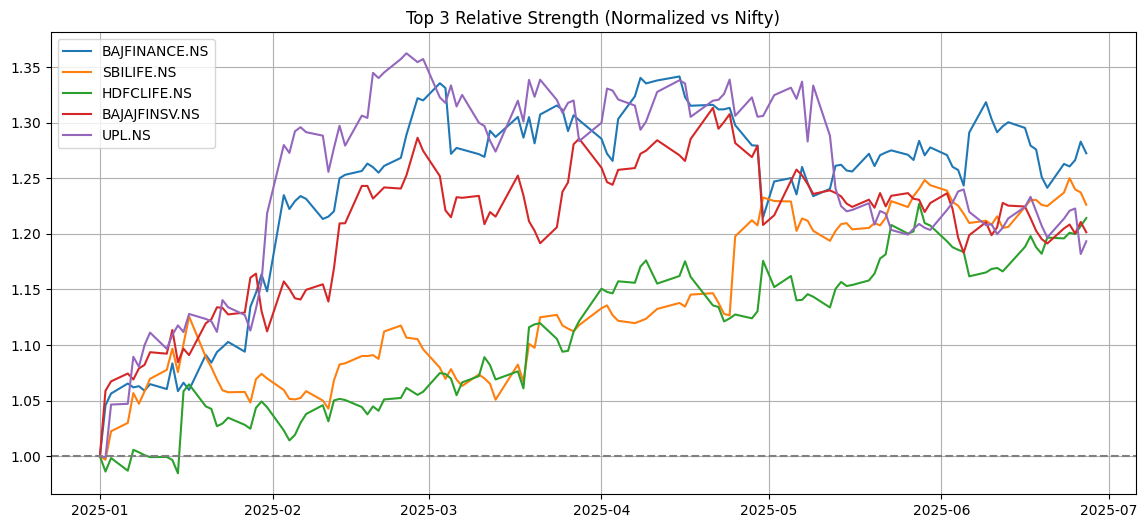

In [6]:
# Optional: Plot Top 3 RS charts
top_3 = latest_rs_df.head(5).index

plt.figure(figsize=(14, 6))
for symbol in top_3:
    plt.plot(rs_dict[symbol], label=symbol)
plt.axhline(1, color='gray', linestyle='--')
plt.title('Top 3 Relative Strength (Normalized vs Nifty)')
plt.legend()
plt.grid(True)
plt.show()
